# Classification of remote sensing data with adative attribute profiles
This notebook explores the application of **Adaptive Attribute Profiles (AAP)** in multichannel image classification and demonstrates the process of optimizing the stability parameter **Δ (delta)** to enhance classification performance.


- Package install: **morphoaap**

In [ ]:
from IPython.display import clear_output

!pip install morphoaap

clear_output()

- input image download: pavia university

In [ ]:
!wget https://github.com/wonderalexandre/aap/raw/main/example/PaviaU.mat
!wget https://github.com/wonderalexandre/aap/raw/main/example/img_gt.mat
!wget https://github.com/wonderalexandre/aap/raw/main/example/img_train.mat

clear_output()

## 1. Importing common libraries


In [166]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import morphoaap as aap
from sklearn.decomposition import PCA

## 2. Function for dimensionality reduction with PCA

In [8]:
#return PCs
def getPCA(paviaU_image, numPCs = 4):

  d1 = paviaU_image.shape[0]
  d2 = paviaU_image.shape[1]
  d3 = paviaU_image.shape[2]
  paviaU_image_reshape = np.reshape(paviaU_image,(d1*d2, d3))
  
  pca = PCA()
  pca.fit(paviaU_image_reshape)
  imgR = np.dot(paviaU_image,np.transpose(pca.components_))
  imgR = np.reshape(imgR,(d1,d2,d3))
  img_PCA_ = imgR[:,:,0:numPCs]

  #Normalization
  delta = 1 / (np.amax(img_PCA_) - np.amin(img_PCA_))
  img_PCA  = img_PCA_ * delta + (-np.amin(img_PCA_)*delta)
  img_PCA = np.uint8(np.round(img_PCA*255))

  return img_PCA


 # 3. Function for feature extraction with AAP

In [21]:
def featureExtraction(image, attr_type, lambdas, deltaMSER, adj=4):
    nr, nc, bands = image.shape
    image_vector = image.reshape((nr * nc, bands))
    number_of_images_profile = ((len(lambdas) * 2) + 1)

    AAP = np.zeros((number_of_images_profile, nr, nc, bands))
    radiusOfAdj = 1 if adj == 4 else 1.5
    
    for i in range(bands):
        obj = aap.AttributeProfile(image_vector[:, i], nr, nc, radiusOfAdj)
        if(deltaMSER == 0):
            #tradicional attribute profile
            profile = obj.getAP(lambdas, attr_type)
        else:
            #adaptive attribute profile
            profile = obj.getAAP(lambdas, attr_type, deltaMSER)

        AAP[:,:,:,i] = profile.T.reshape(number_of_images_profile, nr, nc)

    final_AAP = AAP[:,:,:,0]
    for i in range(1, bands):
        final_AAP = np.concatenate([final_AAP, AAP[:,:,:,i]],axis=0)

    return final_AAP


## 3.1 Example of EAPs and EAAPs

 - Function to plot profile images

In [25]:
def plotProfiles(profile, number_of_images_profile, number_images_by_row):

        rows = number_of_images_profile // number_images_by_row
        last_cols = 0
        if(number_of_images_profile % number_images_by_row != 0):
            last_cols = number_of_images_profile % number_images_by_row
        num_rows = rows
        if(last_cols > 0):
            num_rows += 1
        num_cols = number_images_by_row
        if(rows == 0):
            num_rows = rows = 1
            num_cols = last_cols
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
        if(num_rows == 1):
            for img in range(num_cols):
                axs[img].axis('off')
                axs[img].imshow(profile[img,:,:], cmap='gray')
                axs[img].set_title('Image: '+ str(img+1) )

        else:
            img = 0
            for l in range(num_rows):
                for c in range(3):
                    if( (l < rows or c < last_cols)):
                        axs[l,c].axis('off')
                        axs[l,c].imshow(profile[img, :,:], cmap='gray')
                        axs[l,c].set_title('Image: '+ str(img+1) )
                        img += 1

        #plt.savefig('./imagens.png')
        plt.show()



In [41]:
# load dataset: university of Pavia
paviaU_mat = sio.loadmat('PaviaU.mat')
paviaU_image = paviaU_mat['paviaU']

image_pca = getPCA(paviaU_image, numPCs=4)
nr, nc, bands = image_pca.shape

lambdas = [100, 500, 1000, 5000]
attr_type=0  #0 → Area; 1 → Diagonal; 2 → Width of the bounding box; 3 → Height of the bounding box; 4 → Volume

EAP = featureExtraction(image_pca, attr_type, lambdas, deltaMSER=0)
number_of_images_profile = ((len(lambdas) * 2) + 1)
number_of_images = number_of_images_profile * bands

AP_band1 = EAP[0:number_of_images_profile, :,:]
AP_band2 = EAP[number_of_images_profile:2*number_of_images_profile, :,:]
AP_band3 = EAP[2*number_of_images_profile:3*number_of_images_profile, :,:]
AP_band4 = EAP[3*number_of_images_profile:4*number_of_images_profile, :,:]

EAAP = featureExtraction(image_pca, attr_type, lambdas, deltaMSER=10)
AAP_band1 = EAAP[0:number_of_images_profile, :,:]
AAP_band2 = EAAP[number_of_images_profile:2*number_of_images_profile, :,:]
AAP_band3 = EAAP[2*number_of_images_profile:3*number_of_images_profile, :,:]
AAP_band4 = EAAP[3*number_of_images_profile:4*number_of_images_profile, :,:]

Attribute Profile


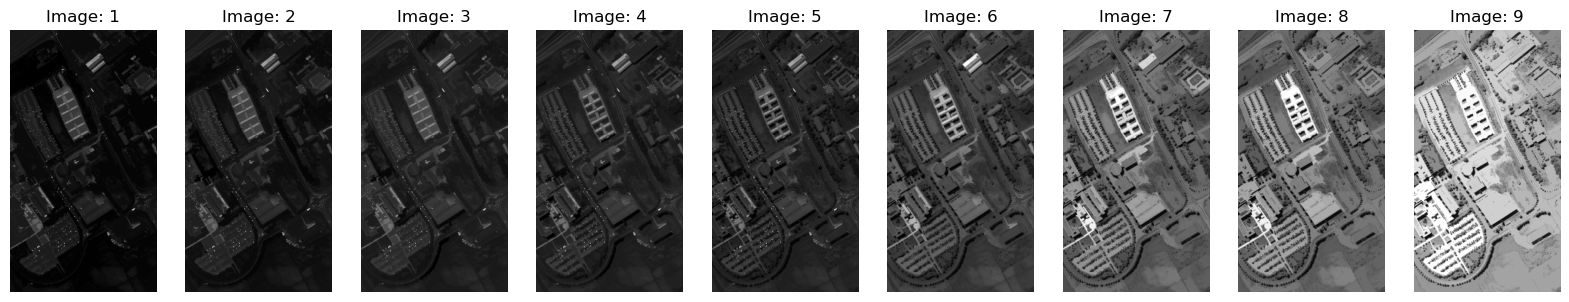

In [42]:
print("Attribute Profile")
plotProfiles(AP_band1, number_of_images_profile, number_of_images_profile)

Adaptive Attribute Profile


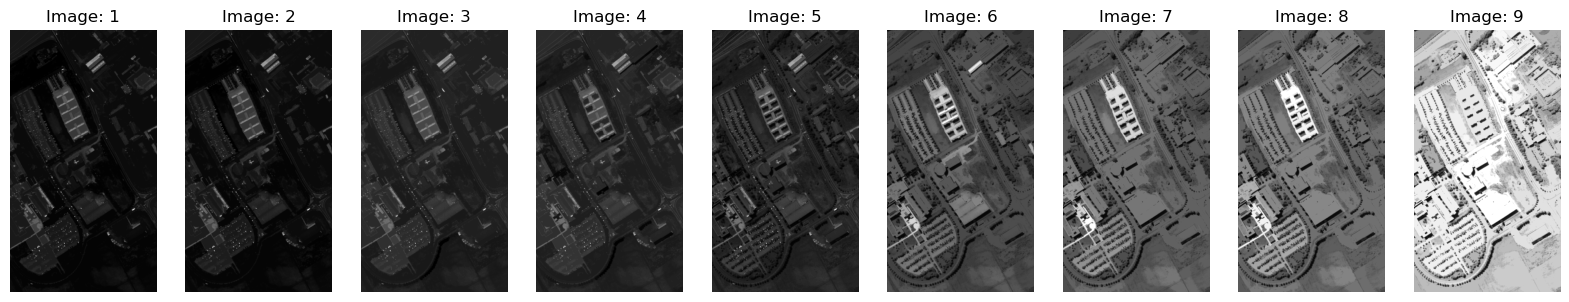

In [43]:
print("Adaptive Attribute Profile")
plotProfiles(AAP_band1, number_of_images_profile, number_of_images_profile)

Difference between AP and AAP


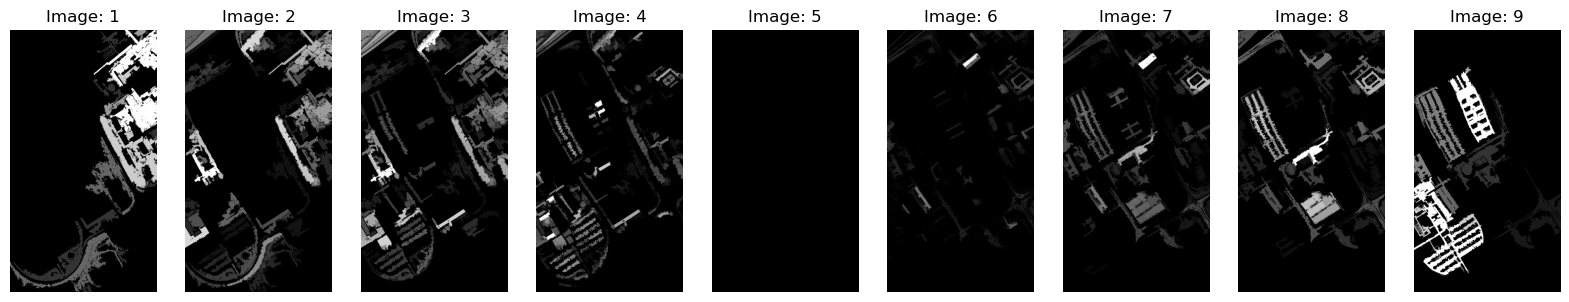

In [44]:
print("Difference between AP and AAP")
plotProfiles(np.abs(AP_band1 - AAP_band1), number_of_images_profile, number_of_images_profile)

# 4. Training model



In [135]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.ensemble import RandomForestClassifier

class RandomForestBasedAttributeProfile(RandomForestClassifier):

  def __init__(self, n_estimators = 100, criterion='gini', max_depth=None, bootstrap=True,  max_features = "sqrt",  random_state=42, image = None, lambdas=[100, 500, 1000, 5000], attributeType=0, deltaMSER=0):
    super().__init__(n_estimators = n_estimators, criterion=criterion, max_depth=max_depth, bootstrap=bootstrap,  max_features = max_features, random_state=random_state)
    self.lambdas = lambdas
    self.attributeType = attributeType
    self.deltaMSER = deltaMSER
    self.image = image
      
    self.EAP_vector = featureExtraction(self.image, self.attributeType, self.lambdas, deltaMSER=self.deltaMSER)
    bands, nr, nc = self.EAP_vector.shape
    self.EAP_vector = self.EAP_vector.reshape((bands, nr * nc)).T
    

  def fit(self, idx, y):
    X = self.EAP_vector[idx]
    super().fit(X, y)
    return self

  def predict(self, idx):
    X = self.EAP_vector[idx]
    return super().predict(X)



from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
class GridSearch():

    def __init__(self, parameters, cv=5, X_val=None, y_val=None):
        self.parameters = parameters
        self.cv=cv
        self.X_val=X_val
        self.y_val=y_val

    def product_dict(self, dic):
        keys = dic.keys()
        vals = dic.values()
        for instance in product(*vals):
            yield dict(zip(keys, instance))

    def bestParameter(self, param):
        return self.parameters_list[max(self.accuracyBest, key=self.accuracyBest.get)][param]

    def bestParameters(self):
        return self.parameters_list[max(self.accuracyBest, key=self.accuracyBest.get)]

    def bestModel(self):
        return self.models[max(self.accuracyBest, key=self.accuracyBest.get)]

    def plot(self, param):
      # Plot it
      plt.figure(figsize=(14, 8))
      plt.style.use('ggplot')
      plt.step(list(self.accuracyBest.keys()), list(self.accuracyBest.values()), where='mid', color='blue')

      bestDelta = self.bestParameter(param)
      plt.plot(bestDelta, self.accuracyBest[bestDelta], 'o', color='red');
      plt.xlabel('$\Delta$')
      plt.ylabel('Accuracy')
      #plt.savefig('./analiseDelta.svg')
      plt.show()

    def fit(self, X, y):

        kf = StratifiedKFold(n_splits=self.cv,  shuffle=True)
        self.accuracyBest = {}
        self.parameters_list = []
        self.models = []
        cont = 1
        for params in self.product_dict(self.parameters):

            print (".") if cont % 10 == 0 else print(".", end=" ")
            cont += 1

            n_estimators = params['n_estimators']
            bootstrap = params['bootstrap']
            max_features = params['max_features']
            max_depth = params['max_depth']
            criterion = params['criterion']
            random_state = params['random_state']
            image = params['image']
            lambdas = params['lambdas']
            attributeType = params['attributeType']
            deltaMSER = params['deltaMSER']

            accuracy = []

            model = RandomForestBasedAttributeProfile(n_estimators = n_estimators,
                                                  bootstrap=bootstrap,
                                                  max_features = max_features,
                                                  max_depth = max_depth,
                                                  criterion = criterion,
                                                  random_state=random_state,
                                                  image=image,
                                                  lambdas=lambdas,
                                                  attributeType=attributeType,
                                                  deltaMSER=deltaMSER)

            if(self.X_val is None):
                for train_index, test_index in kf.split(X, y):
                    X_train, X_val = X[train_index], X[test_index]
                    y_train, y_val = y[train_index], y[test_index]

                    model.fit(X_train, y_train)
                    y_pred_val = model.predict(X_val)
                    accuracy.append( np.mean(y_val == y_pred_val) )
            else:
                model.fit(X, y)
                y_pred_val = model.predict(self.X_val)
                accuracy.append( np.mean(self.y_val == y_pred_val) )

            #print(deltaMSER, np.mean(accuracy))
            self.accuracyBest[len(self.accuracyBest)] = np.mean(accuracy)
            self.parameters_list.append(params)
            self.models.append(model)


from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, recall_score
import pandas as pd
from IPython.display import display

def getMetrics(y_train, y_test, yp_train, yp_pred):

    df = pd.DataFrame({"Metrics": ["Overall Accuracy", "Average Accuracy", "kappa Coefficient"],
              "Train": [accuracy_score(y_train, yp_train), recall_score(y_train, yp_train, average="macro"), cohen_kappa_score(y_train, yp_train)],
              "Test":  [accuracy_score(y_test, yp_pred), recall_score(y_test, yp_pred, average="macro"), cohen_kappa_score(y_test, yp_pred)]})
    df.set_index("Metrics")

    AA_classes_train = recall_score(y_train, yp_train, average=None, labels=np.unique(y_train))
    AA_classes_test = recall_score(y_test, yp_pred, average=None, labels=np.unique(y_test))
    df_classes = pd.DataFrame({"Class":np.unique(y_train), "Train": AA_classes_train, "Test": AA_classes_test})
    df_classes['Class'] = df_classes['Class'].astype(int)
    df_classes.reset_index()
    df_classes.set_index('Class')
    return df, df_classes


# 5. Applied classifier
Experiments performed with the University of Pavia dataset

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


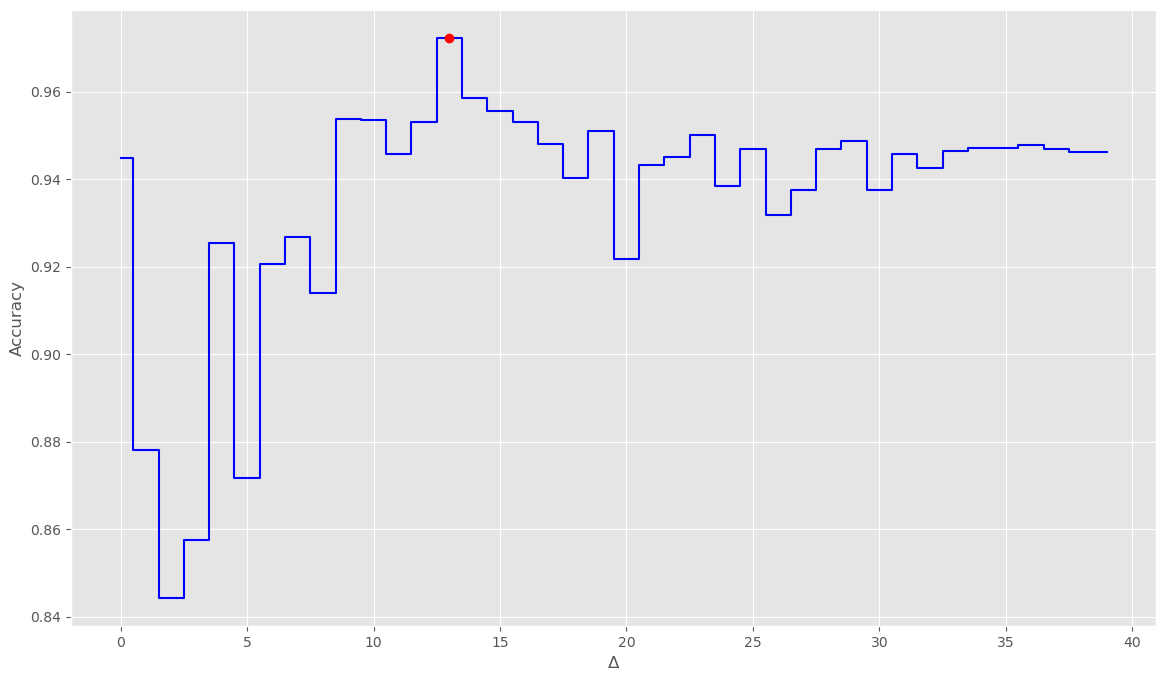

,Classification model,Attribute,Thresholds,OA% (Train),OA% (Test),AA% (Test),Kappa% (Test)
0,Dalla Mura et al. 2010 without AAP,Area,"[100, 500, 1000, 5000]",1.000000,0.944782,0.933440,0.926567
1,Dalla Mura et al. 2010 with AAP,Area,Delta = 13,1.000000,0.972321,0.972990,0.963418


In [50]:
# load dataset: university of Pavia
image = sio.loadmat('PaviaU.mat')['paviaU']
test = sio.loadmat('img_gt.mat')['img_gt']
train = sio.loadmat('img_train.mat')['img_train']

# Train and test sets
test = test.astype(np.float32)
train = train.astype(np.float32)
train = train.reshape(-1)
test = test.reshape(-1)
idx_train = np.array(np.where(train>0)).reshape(-1)
idx_test = np.array(np.where(test>0)).reshape(-1)
y_train = train[idx_train]
y_test  = test[idx_test]

#PCA
image_pca = getPCA(image, numPCs=4)

lambdas = [100, 500, 1000, 5000]
attr_type=0 #area
modelAP = RandomForestBasedAttributeProfile(n_estimators = 100,
                                          bootstrap=True,
                                          max_features = "sqrt",
                                          criterion= 'gini',
                                          random_state=42,
                                          image=image_pca,
                                          lambdas=lambdas,
                                          attributeType=attr_type
                                          )


modelAP.fit(idx_train, y_train)

#grid search / training
parameters_grid ={
    "n_estimators": [100],
    "bootstrap": [True],
    "max_features": ["sqrt"],
    "max_depth" : [None],
    "criterion" :["gini"],
    "random_state": [42],
    "image": [image_pca],
    "lambdas": [lambdas],
    "attributeType": [attr_type],
    "deltaMSER": [i for i in range(0, 40)]
}
gridsearch = GridSearch(parameters_grid, X_val=idx_test, y_val=y_test)
gridsearch.fit(idx_train, y_train)
gridsearch.plot("deltaMSER")
bestDelta = gridsearch.bestParameter("deltaMSER")
modelAAP = gridsearch.bestModel()


#Performance
yp_train_AP = modelAP.predict(idx_train)
yp_test_AP = modelAP.predict(idx_test)

yp_train_AAP = modelAAP.predict(idx_train)
yp_test_AAP = modelAAP.predict(idx_test)


df_AAP, df_classes_AAP = getMetrics(y_train, y_test, yp_train_AAP, yp_test_AAP)
df_AP, df_classes_AP = getMetrics(y_train, y_test, yp_train_AP, yp_test_AP)
dfResults = pd.DataFrame({
                  "Classification model" : ["Dalla Mura et al. 2010 without AAP", "Dalla Mura et al. 2010 with AAP"],
                   "Attribute" : ["Area", "Area"],
                   "Thresholds" : [lambdas, ("Delta = " + str(bestDelta))],

                   "OA% (Train)" : [df_AP["Train"][0], df_AAP["Train"][0]],
                   "OA% (Test)" : [df_AP["Test"][0], df_AAP["Test"][0]],
                   "AA% (Test)" : [df_AP["Test"][1], df_AAP["Test"][1]],
                   "Kappa% (Test)" : [df_AP["Test"][2], df_AAP["Test"][2]]}).style.set_caption('<br><br>The parameters for building the model were extracted from: <i>M. Dalla Mura, J. Atli Benediktsson, B. Waske, and L. Bruzzone, "Extended profiles with morphological attribute filters for the analysis of hyperspectral data", Int. J. Remote Sens., vol. 31, no. 22, pp. 5975–5991, Jul. 2010.</i><br><br>')
dfResults

In [143]:
df_AAP, df_classes_AAP = getMetrics(y_train, y_test, yp_train_AAP, yp_test_AAP)
df_AP, df_classes_AP = getMetrics(y_train, y_test, yp_train_AP, yp_test_AP)

df_classes_AAP = df_classes_AAP.set_index('Class')
df_classes_AP = df_classes_AP.set_index('Class')

df_classes_AP.columns = pd.MultiIndex.from_product([['AP'], df_classes_AP.columns])
df_classes_AAP.columns = pd.MultiIndex.from_product([['AAP'], df_classes_AAP.columns])
df_combined = pd.concat([df_classes_AP, df_classes_AAP], axis=1)

df_combined['Class name'] = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Metal sheets', 'Bare Soil', 'Bitumen', 'Self-blocking Bricks', 'Shadows']
df_combined = df_combined.reset_index()
df_combined = df_combined.set_index(['Class', 'Class name'])

df_combined.style.set_caption('<br><b>Classification by class</b><br>')

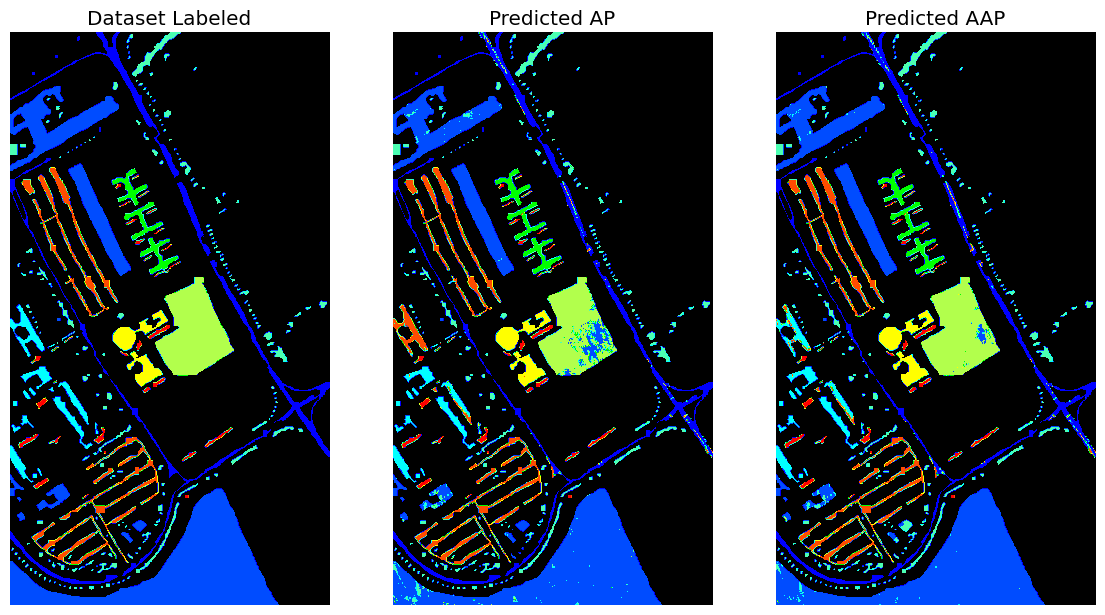

In [174]:
cmap = matplotlib.colors.ListedColormap([(0,0,0,1),(0,0,1,1),(0,0.3,1,1),(0,1,1,1),(0.3,1,0.7,1),(0,1,0,1),(0.7,1,0.3,1),(1,1,0,1),(1,0.3,0,1),(1,0,0,1)])
nr, nc, bands = image.shape

output_label = np.zeros(nr*nc)
output_label[idx_train] = y_train
output_label[idx_test] = y_test

output_AP = np.zeros(nr*nc)
output_AP[idx_train] = yp_train_AP
output_AP[idx_test] = yp_test_AP

output_AAP = np.zeros(nr*nc)
output_AAP[idx_train] = yp_train_AAP
output_AAP[idx_test] = yp_test_AAP

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 10))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.imshow(np.reshape(output_label, (nr, nc)), cmap=cmap)
ax1.set_title('Dataset Labeled')

ax2.imshow(np.reshape(output_AP, (nr, nc)), cmap=cmap)
ax2.set_title('Predicted AP')

ax3.imshow(np.reshape(output_AAP, (nr, nc)), cmap=cmap)
ax3.set_title('Predicted AAP')
plt.show()